In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import table
import datetime as dt 
# dt as time_series operation
%matplotlib inline
# for display dataframe
from IPython.display import display
from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
# ignore warning
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
# storage
from google.datalab import Context
import google.datalab.bigquery as bq
try:
  from StringIO import StringIO
except ImportError:
  from io import BytesIO as StringIO
# ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import xgboost as xgb

/usr/local/envs/py3env/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
# square scale
import matplotlib.scale as mscale
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import matplotlib.ticker as ticker
import numpy as np

class SquareRootScale(mscale.ScaleBase):
    """
    ScaleBase class for generating square root scale.
    """

    name = 'squareroot'

    def __init__(self, axis, **kwargs):
        mscale.ScaleBase.__init__(self)

    def set_default_locators_and_formatters(self, axis):
        axis.set_major_locator(ticker.AutoLocator())
        axis.set_major_formatter(ticker.ScalarFormatter())
        axis.set_minor_locator(ticker.NullLocator())
        axis.set_minor_formatter(ticker.NullFormatter())

    def limit_range_for_scale(self, vmin, vmax, minpos):
        return  max(0., vmin), vmax

    class SquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform_non_affine(self, a): 
            return np.array(a)**0.5

        def inverted(self):
            return SquareRootScale.InvertedSquareRootTransform()

    class InvertedSquareRootTransform(mtransforms.Transform):
        input_dims = 1
        output_dims = 1
        is_separable = True

        def transform(self, a):
            return np.array(a)**2

        def inverted(self):
            return SquareRootScale.SquareRootTransform()

    def get_transform(self):
        return self.SquareRootTransform()

mscale.register_scale(SquareRootScale)
'''
fig, ax = plt.subplots(1)

ax.plot(np.arange(0, 9)**2, label='$y=x^2$')
ax.legend()

ax.set_yscale('squareroot')
ax.set_yticks(np.arange(0,9,2)**2)
ax.set_yticks(np.arange(0,8.5,0.5)**2, minor=True)

plt.show()
''';

# IO

In [3]:
!pip install -U xgboost

  Using cached https://files.pythonhosted.org/packages/54/21/8b2ec99862903a6d3aed62ce156d21d114b8666e669c46d9e54041df9496/xgboost-0.81-py2.py3-none-manylinux1_x86_64.whl
  Found existing installation: xgboost 0.6a2
    Uninstalling xgboost-0.6a2:
      Successfully uninstalled xgboost-0.6a2


In [4]:
import xgboost

In [5]:
xgboost.__version__

'0.6'

In [6]:
%gcs read --object gs://kk_data/ft_satisfaction.csv -v df_ft_satis

In [7]:
df_ft_satis = pd.read_csv(StringIO(df_ft_satis))

In [8]:
%gcs read --object gs://kk_data/ft_day_listen.csv -v df_ft_day_listen

In [9]:
df_ft_day_listen = pd.read_csv(StringIO(df_ft_day_listen))
df_train = pd.merge(df_ft_day_listen, df_ft_satis, how='left',on=['msno'])

In [10]:
%gcs read --object gs://kk_data/sub_ft_satisfaction.csv -v df_sub_ft_satis

In [11]:
%gcs read --object gs://kk_data/sub_ft_day_listen.csv -v df_sub_ft_day_listen

In [12]:
df_sub_ft_day_listen = pd.read_csv(StringIO(df_sub_ft_day_listen))
df_sub_ft_satis = pd.read_csv(StringIO(df_sub_ft_satis))
df_sub = pd.merge(df_sub_ft_day_listen, df_sub_ft_satis, how='left',on=['msno'])

df_sub.is_churn = np.nan

In [13]:
%gcs read --object gs://kk_data/members_v3.csv -v members

In [14]:
df_members =pd.read_csv(StringIO(members))

In [15]:
df_data = df_train.append(df_sub)
df_data = pd.merge(df_data, df_members, how='left',on=['msno'])
gender_encode = {'male':1, 'female':2}
df_data.gender = df_data.gender.map(gender_encode)
# change feature name
df_data = df_data.rename(columns={'day_listen':'six_month_day_listen','user_latent_satisfaction':'six_month_satis'})
# missing value 
print('-'*10,'missing value summary','-'*10)
pd.set_option('display.float_format', lambda x: '%.3f' % x)
print(df_data.isnull().sum() / len(df_data))

---------- missing value summary ----------
msno                     0.000
is_churn                 0.506
six_month_day_listen     0.173
six_month_satis          0.173
city                     0.123
bd                       0.123
gender                   0.646
registered_via           0.123
registration_init_time   0.123
dtype: float64


In [16]:
df_data.head()

,msno,is_churn,six_month_day_listen,six_month_satis,city,bd,gender,registered_via,registration_init_time
0,0nB9bTDIfGnfO+0TI5mI26X9oNuy/T4fIzND+D+RcQ4=,0.000,nan,nan,nan,nan,nan,nan,nan
1,2G9f1kCzNUsrpHaOKlHzK11vmtC9HfXmvYmHqAlr1Yc=,0.000,nan,nan,1.000,0.000,nan,7.000,20150826.000
2,QKXNX8FDdZNpmo50ENWER9/xdbjUGwO3euVsYoaYVu8=,0.000,nan,nan,1.000,0.000,nan,7.000,20130825.000
3,QMa4IOS+j5ryiIyE2ywjxjaxUeKFpFNNr8MCMzpbIsc=,0.000,nan,nan,nan,nan,nan,nan,nan
4,RM0u90xU9bIn+1P3yHVW9fuF2RvPrsEoaRJazS3sSy8=,0.000,nan,nan,nan,nan,nan,nan,nan


# Member features

## Registered_via

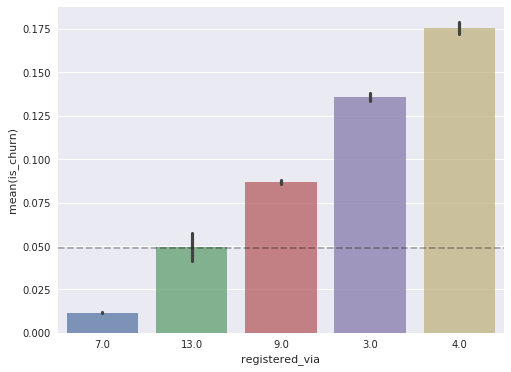

In [17]:
# aggregate result in order to sort 
result_reg = df_data.groupby(["registered_via"])['is_churn'].mean().reset_index().sort_values('is_churn')
# make plot
fig, ax = plt.subplots(figsize=(8,6))
sns.barplot(x='registered_via',y='is_churn',data=df_data,order=result_reg['registered_via'],ax=ax,alpha=.75)
ax.axhline(0.049,linestyle='dashed', c='black',alpha = .3)

In [18]:
df_data.registered_via = df_data.registered_via.fillna(-1)
df_data.six_month_day_listen = df_data.six_month_day_listen.fillna(-1)
df_data.six_month_satis = df_data.six_month_satis.fillna(-1)

### Modeling

In [19]:
def model_training_rf(training_data,testing_data):
  # splits train and validation set
  X = training_data.drop(labels=['msno','is_churn'],axis=1)
  Y = training_data['is_churn']
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2,random_state = 2)
  # Training ~ 01:45s
  model = RandomForestClassifier(random_state=2,n_estimators=300,
                           min_samples_split=0.05,n_jobs=-1,class_weight={0 :0.45,1 :0.55})
  model.fit(X_train,Y_train)
  
  # caculating E_val

  model_probs = model.predict_proba(X_val)
    # [:,1] to show the prob to is_churn = 1
  model_val_score = log_loss(Y_val,model_probs[:,1])
  
  # predict on testing set
  model_pred_testing_set = model.predict_proba(testing_data.drop(labels=['msno','is_churn'],axis=1))
  model_pred_testing_set = model_pred_testing_set[:,1] # take out the prob if is_churn = 1
  submission = pd.DataFrame({"msno": testing_data.msno})
  submission.insert(1,column='is_churn',value=model_pred_testing_set)
  
  return model, model_val_score, submission

In [20]:
def model_training_xgb(training_data,testing_data):
  # splits train and validation set
  X = training_data.drop(labels=['msno','is_churn'],axis=1)
  Y = training_data['is_churn']
  X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2,random_state = 2)
  # model
  xgb_watchlist = [(X_train, Y_train), (X_val, Y_val)]
  model = xgb.XGBClassifier(learning_rate=0.08, max_depth=4,n_estimators=300,\
                 subsample=0.5, seed=2,missing=-1)
  model.fit(X_train, Y_train,eval_set=xgb_watchlist,eval_metric='logloss',
            early_stopping_rounds=20,verbose=70)
  # caculating E_val

  model_probs = model.predict_proba(X_val)
    # [:,1] to show the prob to is_churn = 1
  model_val_score = log_loss(Y_val,model_probs[:,1])
  
  # predict on testing set
  model_pred_testing_set = model.predict_proba(testing_data.drop(labels=['msno','is_churn'],axis=1))
  model_pred_testing_set = model_pred_testing_set[:,1] # take out the prob if is_churn = 1
  submission = pd.DataFrame({"msno": testing_data.msno})
  submission.insert(1,column='is_churn',value=model_pred_testing_set)
  
  return model, model_val_score, submission

In [21]:
df_train, df_sub = df_data[:len(df_train)], df_data[len(df_train):]
print(df_train.columns)
print(df_sub.columns)
reg_via_fts = ['msno','is_churn','six_month_day_listen', 'six_month_satis','registered_via']

Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time'],
      dtype='object')
Index(['msno', 'is_churn', 'six_month_day_listen', 'six_month_satis', 'city',
       'bd', 'gender', 'registered_via', 'registration_init_time'],
      dtype='object')


In [ ]:
reg_via_model, reg_via_val_score,\
reg_via_pred = model_training_rf(df_train[reg_via_fts],df_sub[reg_via_fts])

In [ ]:
reg_via_model_xgb, reg_via_val_score_xgb,\
reg_via_pred_xgb = model_training_xgb(df_train[reg_via_fts],df_sub[reg_via_fts])

In [ ]:
print('day_listen + user_letent_satisfaction logloss val: ',0.192158)
print('reg_via log_loss val xgb: ',np.around(reg_via_val_score_xgb,decimals=6))
print('reg_via log_loss val rf: ',np.around(reg_via_val_score,decimals=6))
print('-'*20,'LB','-'*20)
print('reg_via log_loss LB : ',0.13264)

In [ ]:
reg_via_pred_xgb.to_csv("/content/datalab/sub_reg_via_xgb_pred.csv", index=False)

In [ ]:
!gsutil cp '/content/datalab/sub_reg_via_xgb_pred.csv' 'gs://kk_data/submission/sub_reg_via_xgb_pred.csv';

## Age

In [ ]:
display(df_data[['bd']].describe())
# how many % of meanful values? 
meaningful = (df_data.bd > 0 ) & (df_data.bd < 90)
print('Ages between 0 ~ 90   :  %.3f   ' %( len(df_data[meaningful]) / len(df_data) ))

In [ ]:
sns.set(font_scale=1.56)
from pandas.plotting import table

# create fig and ax 
with sns.axes_style('white'):

    fig, [ax1, ax2] = plt.subplots(1,2, figsize=(25,10))
# distribution
    NOT_churn = ( (df_data.is_churn == 0) & (df_data.bd > 0 ) & (df_data.bd < 90) )
    churn = ( (df_data.is_churn == 1) & (df_data.bd > 0 ) & (df_data.bd < 90) )
    bins= 25
    sns.distplot(df_data.loc[NOT_churn,'bd'],kde=False,label='NOT_churn',ax=ax1,norm_hist=True,bins=bins)
    sns.distplot(df_data.loc[churn,'bd'],kde=False,label='churn',ax=ax1,norm_hist=True,bins=bins)
    ax1.legend()
    ax1.axvline(26,linestyle='dashed',c='black',alpha=.5)

# feature engineering
# create feature  bd<26 == 1, bd>26 ==0 , other = -1
    condition = df_data.bd < 26
    df_data['age_under_26'] = df_data.bd.apply(lambda x: 1 if 0 < x <= 26 else 0 if 26 < x <= 90 else -1)

# prepare table (% of each value)
    df_percent = pd.DataFrame( df_data['age_under_26'].value_counts().sort_index() / len(df_data) ).round(3) 
# barplot with percent table
    sns.barplot(x='age_under_26',y='is_churn',data=df_data,ax=ax2)
    ax2.axhline(0.049,linestyle='dashed', c='black',alpha = .3)
    table(ax2, df_percent,bbox=[0.035, 0.72, 0.2, 0.27])

### Modeling

In [ ]:
# split and prepare features 
df_train = df_data[:len(df_train)]
df_sub = df_data[len(df_train):]
print(df_train.columns)
print(df_sub.columns)
age_fts = reg_via_fts + ['age_under_26']
exclude_list = ['msno','is_churn']

In [ ]:
print('training using features:' ,[fts for fts in age_fts if fts not in exclude_list])
age_model_xgb, age_val_score_xgb,\
age_pred_xgb = model_training_xgb(df_train[age_fts],df_sub[age_fts])

In [ ]:
age_pred_xgb.to_csv("/content/datalab/sub_age_xgb_pred.csv", index=False)
!gsutil cp '/content/datalab/sub_age_xgb_pred.csv' 'gs://kk_data/submission/sub_age_xgb_pred.csv';

print('reg_via logloss val: ',0.164043)
print('reg_via logloss LB: ',0.13264)
print('-'*20,' + age','-'*20)
print('age log_loss LB : ',0.161515)
print('age log_loss LB : ',0.13161)

# Transactions features
## IO

In [ ]:
'''
# first time you for merging data
%gcs read --object gs://kk_data/transactions.csv -v trans

%gcs read --object gs://kk_data/transactions_v2.csv -v trans_v2

%%time
df_trans = pd.read_csv(StringIO(trans))
df_trans_v2 = pd.read_csv(StringIO(trans_v2))
df_trans_all = pd.concat([df_trans,df_trans_v2])
df_train_trans = pd.merge(df_train[['msno','is_churn']],df_trans_all,how='left',on=['msno'])
df_sub_trans = pd.merge(df_sub[['msno','is_churn']],df_trans_all,how='left',on=['msno'])

df_train_trans.to_csv("/content/datalab/df_train_trans_merged.csv", index=False)
!gsutil cp '/content/datalab/df_train_trans_merged.csv' 'gs://kk_data/df_train_trans_merged.csv';

df_sub_trans.to_csv("/content/datalab/df_sub_trans_merged.csv", index=False)
!gsutil cp '/content/datalab/df_sub_trans_merged.csv' 'gs://kk_data/df_sub_trans_merged.csv';
''';

In [ ]:
%gcs read --object gs://kk_data/df_train_trans_merged.csv -v trans

In [ ]:
%gcs read --object gs://kk_data/df_sub_trans_merged.csv -v sub_trans

In [ ]:
%%time
df_train_trans = pd.read_csv(StringIO(trans))
df_sub_trans = pd.read_csv(StringIO(sub_trans))

In [ ]:
df_train_trans.shape, df_sub_trans.shape

In [ ]:
def dtype_compressor(df):
  #object 
  # when unique ratio > 0.5, catogory stands less memory than object
  converted_obj = pd.DataFrame()
  df_obj = df.select_dtypes(include=['object'])
  for col in df_obj.columns:
    converted_obj.loc[:,col] = df_obj.loc[:,col].astype('category')

  # numbers
  df_down_num = pd.DataFrame()
  df_num = df.select_dtypes(include=['number'])
  for col in df_num.columns:
    df_down_num.loc[:,col] = pd.to_numeric(df_num.loc[:,col],downcast='signed')

  # merge
  df = pd.concat([converted_obj,df_down_num],axis=1)
  
  del converted_obj, df_obj, df_down_num, df_num  
  
  return df

In [ ]:
def fast_datetime(s):
    dates = {date:pd.to_datetime(date,format='%Y%m%d') for date in s.unique()}
    return s.map(dates)

In [ ]:
# rename the columns
date_rename = {'transaction_date':'trans_date', 'membership_expire_date':'mem_expire_date'}
df_train_trans.rename(columns=date_rename,inplace=True)
df_sub_trans.rename(columns=date_rename,inplace=True)

# converting
df_train_trans = dtype_compressor(df_train_trans)
df_sub_trans = dtype_compressor(df_sub_trans)
# 1 mins 40 s (with apply approach)
# vectorlized 15s
d = ['trans_date', 'mem_expire_date']
for col in d:
  df_train_trans[col] = fast_datetime(df_train_trans[col])
  df_sub_trans[col] = fast_datetime(df_sub_trans[col])
# took 6s 
# total about 20~30s for single dataframe

In [ ]:
df_sub_trans.is_churn = np.NaN
print("Traning_set missing:\n",np.around(df_train_trans.isnull().sum() / df_train_trans.shape[0],decimals=3))
print(''*60)
print("_"*60)
print(''*60)
print("Testing_set missing:\n",np.around(df_sub_trans.isnull().sum() / df_sub_trans.shape[0],decimals=3))
# no missing value! we can use trasactions table to filling members (12.3%), uerlogs (23%)

## Glance at transactions

In [ ]:
# sort first for easier exploration
df_train_trans = df_train_trans.sort_values(by=['msno','trans_date'])
df_sub_trans = df_sub_trans.sort_values(by=['msno','trans_date'])
df_train_trans.head()

## Preprocessing
### Date Outlier

In [ ]:
# sort first for easier exploration
df_train_trans = df_train_trans.sort_values(by=['msno','trans_date'])
df_sub_trans = df_sub_trans.sort_values(by=['msno','trans_date'])

# build membership
df_train_trans = df_train_trans.eval('membership = mem_expire_date - trans_date')
df_sub_trans = df_sub_trans.eval('membership = mem_expire_date - trans_date')

# now vectorlized
df_train_trans['membership_int'] = df_train_trans.membership / np.timedelta64(1,'D')
df_sub_trans['membership_int'] = df_sub_trans.membership / np.timedelta64(1,'D')


# glance 
pd.set_option('display.float_format', lambda x: '%.3f' % x)
display_side_by_side(df_train_trans[['membership_int','payment_plan_days']].describe(),\
                    df_sub_trans[['membership_int','payment_plan_days']].describe())

In [ ]:
# Summarization
print("_"*15," (the training set) df_train_trans ", "_"*15)
print(''*60)
print("_"*30," < -30 days", "_"*30)
print('is_cancel = 0')
min_date = df_train_trans.membership_int.min()
con = ((df_train_trans.membership_int.between(min_date, -30)) & (df_train_trans.is_cancel == 0))
print(''*60)
print(df_train_trans.loc[con,'payment_plan_days'].value_counts().sort_index())
are_0_plan_days = df_train_trans.payment_plan_days.isin([0])
print(''*60)
print("is_cancel = 0 , plan_days = 0" ) 
print(df_train_trans.loc[con & are_0_plan_days, 'actual_amount_paid'].value_counts().sort_index())
# 1449 means 30 days plan , only 1 paid zero, place 30 days also
print(''*60)
print("_"*30," > 450 days", "_"*30)
print('is_cancel = 0')
print(''*60)
print(df_train_trans.loc[df_train_trans.membership > pd.Timedelta('450 days'), 'payment_plan_days'].value_counts().sort_index())
print(''*60)
print('is_cancel = 0 & plan_days = 0')
print(''*60)
con = (df_train_trans.payment_plan_days == 0) & (df_train_trans.membership_int > 450)
print(df_train_trans.loc[con, 'actual_amount_paid'].value_counts().sort_index())
# 100,119,129,149 --> 30days 
#1599.1788 --> 400 days

In [ ]:
def fast_time_delta(s):
    intervals = {interval:pd.to_timedelta(interval,unit='D') for interval in s.unique()}
    return s.map(intervals)

# ------------------------------------------negtive min_date ~ -30 days-------------------------------------------------------------
# is_cancel = 1
  # Clean up by replaceing trans_date 
min_date = df_train_trans.membership_int.min()
con = ((df_train_trans.membership_int.between(min_date, -30)) & (df_train_trans.is_cancel == 1))
df_train_trans.loc[con, 'mem_expire_date'] = df_train_trans.loc[con, 'trans_date'] 
# is_cancel = 0
  # Clean up use:
    # engineered payment_plan_days_time_delta --> plan_days_td
    # payment_plan_days not 0 --> expire = trans + plan_days_td
    # payment_plan_days is 0  --> expire = trans + 30 days (explored first with actual_amount_paid)
    # the actual_amount_paid could be check on Summarization above

df_train_trans['plan_days_td'] = fast_time_delta(df_train_trans.payment_plan_days)


  # not_0_plan_days
con = ((df_train_trans.membership_int.between(min_date,-30)) & (df_train_trans.is_cancel == 0))
not_0_plan_days = ~ (df_train_trans.payment_plan_days.isin([0]))
df_train_trans.loc[con & not_0_plan_days,'mem_expire_date'] = df_train_trans.loc[con & not_0_plan_days,'trans_date'] + \
df_train_trans.loc[con & not_0_plan_days,'plan_days_td']

  # are_0_plan_days
are_0_plan_days = df_train_trans.payment_plan_days.isin([0])
df_train_trans.loc[con & are_0_plan_days,'mem_expire_date'] = df_train_trans.loc[con & are_0_plan_days,'trans_date'] + pd.Timedelta('30 days')

#  -----------------------------------------positive 450 days ~ max_date-------------------------------------------------------------


# is_cancel = 1
  # Clean up by replaceing trans_date 
max_date = df_train_trans.membership_int.max()
con = ((df_train_trans.membership_int.between(450, max_date)) & (df_train_trans.is_cancel == 1))
df_train_trans.loc[con, 'mem_expire_date'] = df_train_trans.loc[con, 'trans_date'] 

# is_cancel = 0
  # Clean up use:
    # payment_plan_days not 0 --> expire = trans + plan_days_td
    # payment_plan_days is 0 
      # the  30 days case --> expire = trans + 30 days
      # the 400 days case --> expire = trnas + 400 days


# payment_plan_day not 0
con = ((df_train_trans.membership_int.between(450,max_date)) & (df_train_trans.is_cancel == 0))
not_0_plan_days = ~ (df_train_trans.payment_plan_days.isin([0]))
df_train_trans.loc[con & not_0_plan_days,'mem_expire_date'] = df_train_trans.loc[con & not_0_plan_days,'trans_date'] + \
df_train_trans.loc[con & not_0_plan_days,'plan_days_td']

# plan_days = 0 infer by actual_amount_paid
# the 30 days case

con = (df_train_trans.payment_plan_days == 0) & (df_train_trans.membership_int > 450)

paid_30_days = df_train_trans.actual_amount_paid.isin([100,119,129,149])
df_train_trans.loc[con & paid_30_days , 'mem_expire_date'] = \
df_train_trans.loc[con & paid_30_days, 'trans_date'] + pd.Timedelta('30 days')

# plan_days = 0 infer by actual_amount_paid
# the 400 days case
paid_400_days = df_train_trans.actual_amount_paid.isin([1599,1788])
df_train_trans.loc[con & paid_400_days , 'mem_expire_date'] = \
df_train_trans.loc[con & paid_400_days, 'trans_date'] + pd.Timedelta('400 days')

In [ ]:
# Summirization
print("_"*15," (the testing set) df_sub_trans ", "_"*15)
print(''*60)
print("_"*30," < -30 days", "_"*30)
print('is_cancel = 0')
min_date = df_sub_trans.membership_int.min()
con = ((df_sub_trans.membership_int.between(min_date, -30)) & (df_sub_trans.is_cancel == 0))
print(''*60)
print(df_sub_trans.loc[con,'payment_plan_days'].value_counts().sort_index())
are_0_plan_days = df_sub_trans.payment_plan_days.isin([0])
print(''*60)
print("is_cancel = 0 , plan_days = 0" ) 
print(df_sub_trans.loc[con & are_0_plan_days, 'actual_amount_paid'].value_counts().sort_index())
# 1449 means 30 days plan , only 1 paid zero, place 30 days also
print(''*60)
print("_"*30," > 450 days", "_"*30)
print('is_cancel = 0')
print(''*60)
print(df_sub_trans.loc[df_sub_trans.membership > pd.Timedelta('450 days'), 'payment_plan_days'].value_counts().sort_index())
print(''*60)
print('is_cancel = 0 & plan_days = 0')
print(''*60)
con = (df_sub_trans.payment_plan_days == 0) & (df_sub_trans.membership_int > 450)
print(df_sub_trans.loc[con, 'actual_amount_paid'].value_counts().sort_index())
# 100,119,129,149 --> 30days 
#1599.1788 --> 400 days

In [ ]:
# ------------------------------------------negtive min_date ~ -30 days-------------------------------------------------------------
# is_cancel = 1
  # Clean up by replaceing trans_date 
min_date = df_sub_trans.membership_int.min()
con = ((df_sub_trans.membership_int.between(min_date, -30)) & (df_sub_trans.is_cancel == 1))
df_sub_trans.loc[con, 'mem_expire_date'] = df_sub_trans.loc[con, 'trans_date'] 
# is_cancel = 0
  # Clean up use:
    # engineered payment_plan_days_time_delta --> plan_days_td
    # payment_plan_days not 0 --> expire = trans + plan_days_td
    # payment_plan_days is 0  --> expire = trans + 30 days (explored first with actual_amount_paid)
    # the actual_amount_paid could be check on Summirization above

df_sub_trans['plan_days_td'] = fast_time_delta(df_sub_trans.payment_plan_days)


  # not_0_plan_days
con = ((df_sub_trans.membership_int.between(min_date,-30)) & (df_sub_trans.is_cancel == 0))
not_0_plan_days = ~ (df_sub_trans.payment_plan_days.isin([0]))
df_sub_trans.loc[con & not_0_plan_days,'mem_expire_date'] = df_sub_trans.loc[con & not_0_plan_days,'trans_date'] + \
df_sub_trans.loc[con & not_0_plan_days,'plan_days_td']

  # are_0_plan_days
  # the only one record paid 0 just fill with 30 days treated as NOISE
are_0_plan_days = df_sub_trans.payment_plan_days.isin([0])
df_sub_trans.loc[con & are_0_plan_days,'mem_expire_date'] = df_sub_trans.loc[con & are_0_plan_days,'trans_date'] + pd.Timedelta('30 days')

#  -----------------------------------------positive 450 days ~ max_date-------------------------------------------------------------


# is_cancel = 1
  # Clean up by replaceing trans_date 
max_date = df_sub_trans.membership_int.max()
con = ((df_sub_trans.membership_int.between(450, max_date)) & (df_sub_trans.is_cancel == 1))
df_sub_trans.loc[con, 'mem_expire_date'] = df_sub_trans.loc[con, 'trans_date'] 

# is_cancel = 0
  # Clean up use:
    # payment_plan_days not 0 --> expire = trans + plan_days_td
    # payment_plan_days is 0 
      # the  30 days case --> expire = trans + 30 days
      # the 400 days case --> expire = trnas + 400 days


# payment_plan_day not 0
con = ((df_sub_trans.membership_int.between(450,max_date)) & (df_sub_trans.is_cancel == 0))
not_0_plan_days = ~ (df_sub_trans.payment_plan_days.isin([0]))
df_sub_trans.loc[con & not_0_plan_days,'mem_expire_date'] = df_sub_trans.loc[con & not_0_plan_days,'trans_date'] + \
df_sub_trans.loc[con & not_0_plan_days,'plan_days_td']

# plan_days = 0 infer by actual_amount_paid
# the 30 days case

con = (df_sub_trans.payment_plan_days == 0) & (df_sub_trans.membership_int > 450)

paid_30_days = df_sub_trans.actual_amount_paid.isin([100,119,129,149])
df_sub_trans.loc[con & paid_30_days , 'mem_expire_date'] = \
df_sub_trans.loc[con & paid_30_days, 'trans_date'] + pd.Timedelta('30 days')

# plan_days = 0 infer by actual_amount_paid
# the 400 days case
paid_400_days = df_sub_trans.actual_amount_paid.isin([1599])
df_sub_trans.loc[con & paid_400_days , 'mem_expire_date'] = \
df_sub_trans.loc[con & paid_400_days, 'trans_date'] + pd.Timedelta('400 days')

### Drop leaky predictor

In [ ]:
print(df_train_trans[df_train_trans.trans_date > np.datetime64('2017-03-01')].shape)
print(df_sub_trans[df_sub_trans.trans_date > np.datetime64('2017-04-01')].shape)

In [ ]:
df_train_trans = df_train_trans[ ~ (  df_train_trans.trans_date > np.datetime64('2017-03-01')  ) ]
df_train_trans.info()

## Features
### Last_Last_churn

In [ ]:
def ll_churn(df):
  # to avoid mistake by chance, let's sort first
  # at the same time, groupby.cumsum has no argument about ascending, so it's necessary
  
  df = df.sort_values(by=['msno','trans_date'],ascending=True)
  df['next_trans_after'] = df['trans_date'].shift(-1) - df['mem_expire_date']
  df['the_same_user'] = df['msno'] == df['msno'].shift(-1)
  
  # 40 days allow more tolerance about churn
  df['churn_record'] = (df['next_trans_after'] > pd.Timedelta('30 days')) & (df['the_same_user'] == True)
  
  # convert boolen to 1 and 0 
  df['churn_record'] = df['churn_record']*1
  
  # sort_by expire_date
  df = df.sort_values(by=['msno','mem_expire_date'],ascending=False)

  # take out last_last_churn
  ft = df.groupby(by=['msno'],as_index=False).nth(1)[['msno','churn_record']]
  ft = ft.rename(columns={'churn_record':'last_last_churn'})
  
  return ft

In [ ]:
ft_last_last_churn_train = ll_churn(df_train_trans)
ft_last_last_churn_sub = ll_churn(df_sub_trans)

In [ ]:
df_train = pd.merge(df_train,ft_last_last_churn_train,how='left',on=['msno']);
df_sub = pd.merge(df_sub,ft_last_last_churn_train,how='left',on=['msno']);

In [ ]:
# only one trans_record does not have last_last_churn information
df_train.last_last_churn = df_train.last_last_churn.fillna(-1)
df_sub.last_last_churn = df_sub.last_last_churn.fillna(-1)
print('_'*30, 'traning set', '_'*30)
print(''*60)
print(df_train.last_last_churn.value_counts())
print('_'*30, 'testing set', '_'*30)
print(''*60)
print(df_sub.last_last_churn.value_counts())

In [ ]:
result_ll_churn = df_train.groupby(["last_last_churn"])['is_churn'].mean().reset_index().sort_values('is_churn')
fig, ax = plt.subplots(figsize=(12,8))
sns.barplot(x='last_last_churn', y='is_churn', data=df_train,ax=ax,order=result_ll_churn['last_last_churn'])
ax.axhline(0.049,linestyle='dashed', c='black',alpha = .3)

### Modeling

In [ ]:
# split and prepare features 
print(df_train.columns)
print(df_sub.columns)
ll_churn_fts = age_fts + ['last_last_churn']
exclude_list = ['msno','is_churn']

In [ ]:
print('training using features: \n' ,[fts for fts in ll_churn_fts if fts not in exclude_list])
ll_churn_model_xgb, ll_churn_val_score_xgb,\
ll_churn_pred_xgb = model_training_xgb(df_train[ll_churn_fts],df_sub[ll_churn_fts])

In [ ]:
ll_churn_pred_xgb.to_csv("/content/datalab/sub_ll_churn_xgb_pred.csv", index=False)
!gsutil cp '/content/datalab/sub_ll_churn_xgb_pred.csv' 'gs://kk_data/submission/sub_ll_churn_xgb_pred.csv';

print('age logloss val: ',0.16151)
print('age logloss LB: ',0.13161)
print('-'*20,' + ll_churn','-'*20)
print('ll_churn log_loss val : ',0.15347)
print('ll_churn log_loss LB : ',0.12698)

## Trans_times

In [ ]:
# Feature Engineering and merge
ft_trans_times_train = df_train_trans[['msno','trans_date']].groupby(by=['msno'],as_index=False).count().\
rename(columns={'trans_date':'trans_times'});
ft_trans_times_sub = df_sub_trans[['msno','trans_date']].groupby(by=['msno'],as_index=False).count().\
rename(columns={'trans_date':'trans_times'});
df_train = pd.merge(df_train, ft_trans_times_train, how='left', on=['msno'])
df_sub = pd.merge(df_sub, ft_trans_times_sub,how='left', on=['msno'])

In [ ]:
df_data = df_train.append(df_sub)
sns.set(font_scale=1.56)
# create fig and ax 
with sns.axes_style('white'):

  fig, [ax1, ax2] = plt.subplots(1,2, figsize=(25,10))
    
  sns.distplot(df_data.loc[(df_data.is_churn == 0), 'trans_times'],kde=False, label='NOT_churn',ax=ax1,norm_hist=True)
  sns.distplot(df_data.loc[(df_data.is_churn == 1), 'trans_times'],kde=False, label='churn',ax=ax1,norm_hist=True)
  ax1.legend()
  ax1.set_yscale('log')

  # feature enineering
  # New, Trying, OneYear, TwoYear, Stable
  max_trans = df_data.trans_times.max()
  bins = [0,1,6,12,24,max_trans]

  # period = nodes - 1 --> labels = np.arange(len( bins) -1 )
  df_data['client_level_code'] = pd.cut(df_data.trans_times, bins, labels= np.arange( len( bins) - 1 ) )
  df_data['client_level_code'] = df_data['client_level_code'].astype('int8')

  # prepare table (% of each value)
  df_percent = pd.DataFrame( df_data['client_level_code'].value_counts().sort_index() / len(df_data) ).round(3) 
  # barplot of churn rate
  sns.barplot(x='client_level_code',y='is_churn',data=df_data,ax=ax2)
  ax2.axhline(0.049,linestyle='dashed', c='black',alpha = .3)
  table(ax2, df_percent,bbox=[0.80, 0.72, 0.2, 0.27])

### Modeling

In [ ]:
# split and prepare features 
df_train, df_sub = df_data[:len(df_train)], df_data[len(df_train):]
print(df_train.columns)
print(df_sub.columns)
client_level_code_fts = ll_churn_fts + ['client_level_code']
exclude_list = ['msno','is_churn']

In [ ]:
print('training using features: \n' ,[fts for fts in client_level_code_fts if fts not in exclude_list])
client_level_code_model_xgb, client_level_code_val_score_xgb,\
client_level_code_pred_xgb = model_training_xgb(df_train[client_level_code_fts],df_sub[client_level_code_fts])

In [ ]:
client_level_code_pred_xgb.to_csv("/content/datalab/sub_client_level_code_xgb_pred.csv", index=False)
!gsutil cp '/content/datalab/sub_client_level_code_xgb_pred.csv' 'gs://kk_data/submission/sub_client_level_code_xgb_pred.csv';

print('last_last_churn logloss val: ',0.15347)
print('last_last_churn logloss LB: ',0.12698)
print('-'*20,' + client_level_code','-'*20)
print('client_level_code log_loss val : ',0.14982)
print('client_level_code log_loss LB : ',0.12463)

## Auto_renew explore

In [ ]:
# since cumsum does not support ascending = False, we resort our data with mem_expire_date first
# need to fix sort_problem
df_train_trans = df_train_trans.sort_values(by=['msno'],ascending=False).sort_values(by=['mem_expire_date'],ascending=True)
# apply function groupby.cumsum()
df_train_trans['auto_renew_so_far'] = df_train_trans.groupby(by=['msno'],as_index=False)['is_auto_renew'].cumsum()
# resort with latest expire_date first
df_train_trans.sort_values(by=['msno','mem_expire_date'],ascending=False,inplace=True);
# since cumcount start at 0, we plus one for adjusting
df_train_trans['trans_times_so_far'] = df_train_trans.groupby(by=['msno'],as_index=False)['is_auto_renew'].cumcount(ascending=False) + 1

In [ ]:
agg_result = df_train_trans.groupby(by=['msno'],as_index=False).head(1)
agg_result.eval('ratio_auto_renew = auto_renew_so_far / trans_times_so_far', inplace=True);

In [ ]:
fig, ax = plt.subplots(figsize=(20,8))
sns.distplot(agg_result.ratio_auto_renew,kde=False,ax=ax)
ax.set_yscale('squareroot')
print('ratio of All auto_renew:%.3f'%((agg_result.ratio_auto_renew == 1 ).sum() / len(agg_result)))
print('ratio of All manual_renew:%.3f'%((agg_result.ratio_auto_renew == 0 ).sum() / len(agg_result)))
print('ratio of Mix manual&auto renew:%.3f'%(( (agg_result.ratio_auto_renew < 1) & (agg_result.ratio_auto_renew > 0) ).sum() / len(agg_result)))
print('All_auto_renew churn_rate: %.3f' %(agg_result.query('ratio_auto_renew == 1').is_churn.mean()) )
print('All_manual_renew churn_rate: %.3f' %(agg_result.query('ratio_auto_renew == 0').is_churn.mean()) )

## Last_auto_renew

In [ ]:
# Feature Engineering
# for safe, sorted first
df_train_trans = df_train_trans.sort_values(by=['msno','mem_expire_date'],ascending=False)
df_sub_trans = df_sub_trans.sort_values(by=['msno','mem_expire_date'],ascending=False)
ft_last_auto_renew_train = df_train_trans[['msno','is_auto_renew']].groupby(by=['msno'],as_index=False).head(1)
ft_last_auto_renew_sub = df_sub_trans[['msno','is_auto_renew']].groupby(by=['msno'],as_index=False).head(1)
# feature rename
ft_last_auto_renew_train.rename(columns={'is_auto_renew':'last_auto_renew'}, inplace=True)
ft_last_auto_renew_sub.rename(columns={'is_auto_renew':'last_auto_renew'}, inplace=True)

In [ ]:
df_train = pd.merge(df_train,ft_last_auto_renew_train,how='left',on=['msno'])
df_sub = pd.merge(df_sub,ft_last_auto_renew_sub,how='left',on=['msno'])

In [ ]:
with sns.axes_style('white'):
  fig, ax = plt.subplots(figsize= (12,8) )
# prepare table (% of each value)
  df_percent = pd.DataFrame( df_train['last_auto_renew'].value_counts().sort_index() / len(df_train) ).round(3) 
# barplot with percent table
  sns.barplot(x='last_auto_renew',y='is_churn',data=df_train,ax=ax)
  ax.axhline(0.049,linestyle='dashed', c='black',alpha = .3)
  table(ax, df_percent,bbox=[0.80, 0.72, 0.2, 0.27])

### Modeling

In [ ]:
# split and prepare features 
print(df_train.columns)
print(df_sub.columns)
last_auto_renew_fts = client_level_code_fts + ['last_auto_renew']
exclude_list = ['msno','is_churn']

In [ ]:
print('training using features: \n' ,[fts for fts in last_auto_renew_fts if fts not in exclude_list])
last_auto_renew_model_xgb, last_auto_renew_val_score_xgb,\
last_auto_renew_pred_xgb = model_training_xgb(df_train[last_auto_renew_fts],df_sub[last_auto_renew_fts])

In [ ]:
last_auto_renew_pred_xgb.to_csv("/content/datalab/sub_last_auto_renew_xgb_pred.csv", index=False)
!gsutil cp '/content/datalab/sub_last_auto_renew_xgb_pred.csv' 'gs://kk_data/submission/sub_last_auto_renew_xgb_pred.csv';

print('client_level_code logloss val: ',0.14982)
print('client_level_code logloss LB: ',0.12463)
print('-'*20,' + last_auto_renew','-'*20)
print('last_auto_renew log_loss val : ',0.13419)
print('last_auto_renew log_loss LB : ',0.11617)

## One_month_day_listen

In [ ]:
%bq query -n query
-- one_month_day_listen CTE
WITH features AS (
                   SELECT  msno AS msno , COUNT(msno) AS one_month_day_listen
                   FROM `kkbox-210108.kk_Data.user_logs`
                   WHERE date > 20170201 AND date < 20170228 
                   GROUP BY msno)
SELECT train.msno, features.one_month_day_listen
FROM `kkbox-210108.kk_Data.user_label_201703` AS train
LEFT JOIN features 
        ON   train.msno = features.msno 

In [ ]:
%bq dryrun -q query

In [ ]:
%bq extract -f csv -H -p 'gs://kk_data/ft_one_month_day_listen.csv' -q query --verbose

In [ ]:
%bq query -n query
WITH features AS (
                   SELECT  msno AS msno , COUNT(msno) AS one_month_day_listen
                   FROM `kkbox-210108.kk_Data.user_logs`
                   WHERE date > 20170301 AND date < 20170331 
                   GROUP BY msno)
SELECT sub.msno, features.one_month_day_listen
FROM `kkbox-210108.kk_Data.submission` AS sub
LEFT JOIN features 
        ON   sub.msno = features.msno 

In [ ]:
%bq dryrun -q query

In [ ]:
%bq extract -f csv -H -p 'gs://kk_data/sub_ft_one_month_day_listen.csv' -q query --verbose

In [ ]:
%gcs read --object gs://kk_data/ft_one_month_day_listen.csv -v df_one_month_day_listen

In [ ]:
%gcs read --object gs://kk_data/sub_ft_one_month_day_listen.csv -v df_sub_ft_one_month_day_listen

In [ ]:
ft_train_one_month_day_listen = pd.read_csv(StringIO(df_one_month_day_listen))
ft_sub_one_month_day_listen = pd.read_csv(StringIO(df_sub_ft_one_month_day_listen))

In [ ]:
df_train = pd.merge(df_train, ft_train_one_month_day_listen, how='left',on=['msno'])
df_sub = pd.merge(df_sub, ft_sub_one_month_day_listen, how='left',on=['msno'])

In [ ]:
df_train['one_month_day_listen'] = df_train['one_month_day_listen'].fillna(-1)
df_sub['one_month_day_listen'] = df_sub['one_month_day_listen'].fillna(-1)
fig, ax = plt.subplots( figsize=(20,8) )
churn = (df_train['one_month_day_listen'] > 0) & (df_train.is_churn == 1)
NOT_churn = (df_train['one_month_day_listen'] > 0) & (df_train.is_churn == 0)
bins=25
sns.distplot(df_train.loc[churn,'one_month_day_listen'],kde=False,norm_hist=True,label='churn',ax=ax,bins=bins)
sns.distplot(df_train.loc[NOT_churn,'one_month_day_listen'],kde=False,norm_hist=True,label='NOT_churn',ax=ax,bins=bins)
ax.legend()

### Modeling

In [ ]:
print(df_train.columns)
print(df_sub.columns)
one_month_day_listen_fts = last_auto_renew_fts + ['one_month_day_listen']
exclude_list = ['msno','is_churn']

In [ ]:
print('training using features: \n' ,[fts for fts in one_month_day_listen_fts if fts not in exclude_list])
one_month_day_listen_model_xgb, one_month_day_listen_val_score_xgb,\
one_month_day_listen_pred_xgb = model_training_xgb(df_train[one_month_day_listen_fts],df_sub[one_month_day_listen_fts])

In [ ]:
one_month_day_listen_pred_xgb.to_csv("/content/datalab/sub_one_month_day_listen_xgb_pred.csv", index=False)
!gsutil cp '/content/datalab/sub_one_month_day_listen_xgb_pred.csv' 'gs://kk_data/submission/sub_one_month_day_listen_xgb_pred.csv';

print('last_auto_renew logloss val: ',0.13419)
print('last_auto_renew logloss LB: ',0.11617)
print('-'*20,' + one_month_day_listen','-'*20)
print('one_month_day_listen log_loss val : ',0.13215)
print('one_month_day_listen log_loss LB : ',0.11335)

## Permutation Testing

In [ ]:
import eli5

In [ ]:
training_data, testing_data = df_train[one_month_day_listen_fts], df_sub[one_month_day_listen_fts]
# splits train and validation set
X = training_data.drop(labels=['msno','is_churn'],axis=1)
Y = training_data['is_churn']
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2,random_state = 2)

# model
xgb_watchlist = [(X_train, Y_train), (X_val, Y_val)]
model = xgb.XGBClassifier(learning_rate=0.08, max_depth=4,n_estimators=300,\
                 subsample=0.5, seed=2,missing=-1)
model.fit(X_train, Y_train,eval_set=xgb_watchlist,eval_metric='logloss',
            early_stopping_rounds=20,verbose=70)
# caculating E_val

model_probs = model.predict_proba(X_val)
    # [:,1] to show the prob to is_churn = 1
model_val_score = log_loss(Y_val,model_probs[:,1])
  
# predict on testing set
model_pred_testing_set = model.predict_proba(testing_data.drop(labels=['msno','is_churn'],axis=1))
model_pred_testing_set = model_pred_testing_set[:,1] # take out the prob if is_churn = 1
submission = pd.DataFrame({"msno": testing_data.msno})
submission.insert(1,column='is_churn',value=model_pred_testing_set)
  
#  return model, model_val_score, submission

In [ ]:
from eli5.sklearn import PermutationImportance

In [ ]:
type(X_train)

In [ ]:
# ?
# X_train = X_train.as_matrix()
# X_val = X_val.as_matrix()
# Y_train = Y_train.as_matrix()
# Y_val = Y_val.as_matrix()
print(type(X_train))
xgb_watchlist = [(X_train, Y_train), (X_val, Y_val)]
model.fit(X_train, Y_train,eval_set=xgb_watchlist,eval_metric='logloss',early_stopping_rounds=20,verbose=70)
per = PermutationImportance(model,random_state=1,).fit(X_val,Y_val)
# eli5.show_weights(per, feature_names=X_val.columns.tolist())

In [ ]:
import eli5

In [ ]:
per_html = eli5.explain_weights(per)
per_html

In [ ]:
per_df = eli5.explain_weights_df(per)

feature_names = df_train[one_month_day_listen_fts].drop(labels=['msno','is_churn'],axis=1).columns.tolist()

feature_names
per_df['feature_name'] = ['last_auto_renew','one_month_day_listen','last_last_churn','registered_via',
                         'six_month_day_listen','client_level_code','age_under_26','six_month_satis']

In [ ]:
fig, ax =plt.subplots(figsize=(10,6))
per_df.plot(kind='barh',y='weight',x='feature_name',ax=ax)
ax.invert_yaxis()

In [ ]:
xgb.plot_importance(model,importance_type='gain',show_values=False)